## Assignment 2 - Explicit Numerical Solvers

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from matplotlib import rcParams

rcParams.update({'text.usetex': True,
                 'font.family': 'serif',
                 'font.serif': ['Computer Modern'],
                 'axes.unicode_minus': False,
                 'font.size': 12})

#### Problem 2 - Stability of explicit methods

In [3]:
def R_forward_euler(z):
    return 1 + z

def R_heun(z):
    return 1 + z + (z**2) / 2

def R_runge_kutta_4(z):
    return 1 + z + (z**2) / 2 + (z**3) / 6 + (z**4) / 24

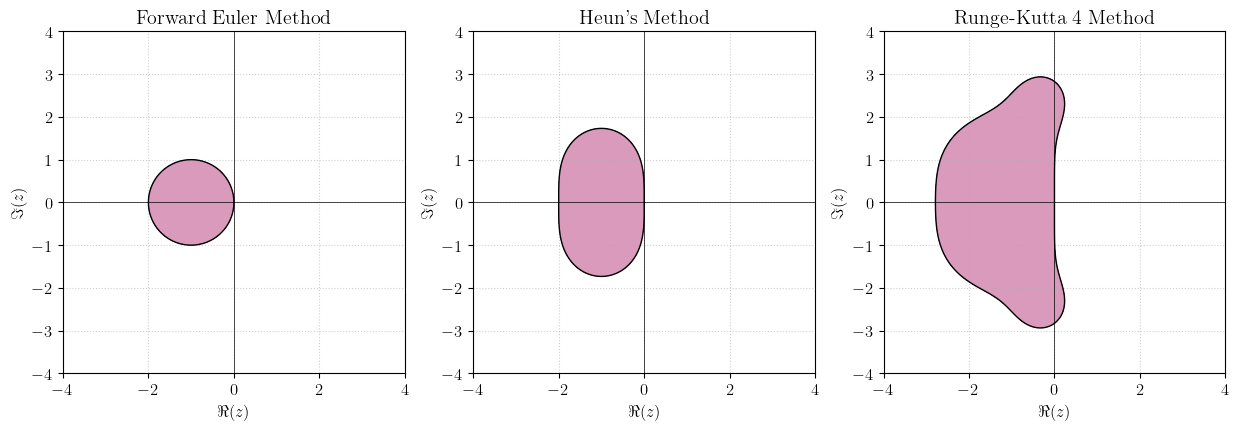

In [4]:
def plot_stability_region(ax, R, title):
    re = np.linspace(-4, 4, 400)
    im = np.linspace(-4, 4, 400)
    Re, Im = np.meshgrid(re, im)

    z = Re + 1j * Im
    
    region = np.abs(R(z))
    
    ax.contourf(Re, Im, region, levels=[0, 1], cmap='magma', alpha=0.5)
    ax.contour(Re, Im, region, levels=[1.0], colors='black', linewidths=1.0)
    ax.axhline(0, color='black', lw=0.5)
    ax.axvline(0, color='black', lw=0.5)
    ax.grid(True, which='both', ls=':', alpha=0.6)
    ax.set_title(title)
    ax.set_xlabel('$\Re(z)$')
    ax.set_ylabel('$\Im(z)$')
    ax.set_aspect('equal')
    
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_stability_region(axs[0], R_forward_euler, 'Forward Euler Method')
plot_stability_region(axs[1], R_heun, "Heun's Method")
plot_stability_region(axs[2], R_runge_kutta_4, 'Runge-Kutta 4 Method')

#### Problem 3 - Simulating the damped nonlinear oscillator

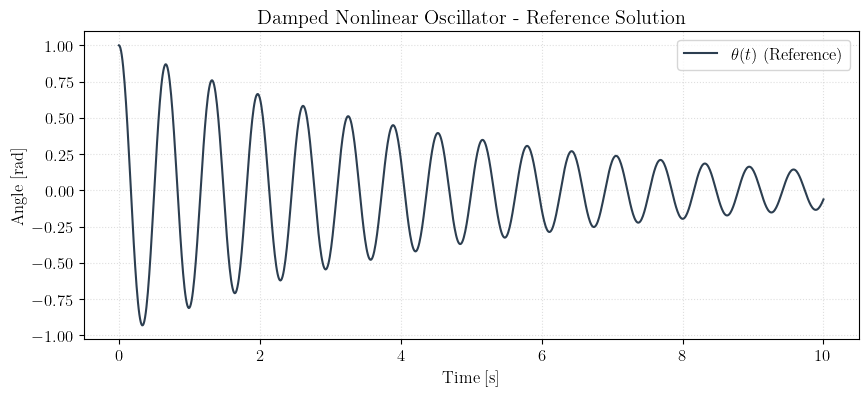

In [19]:
from scipy.integrate import solve_ivp

parameters = {
    "omega_0": 10,
    "xi": 0.02
}

y0 = [1.0, 0.0]
t_span = (0, 10)
t_eval = np.linspace(t_span[0], t_span[1], 1000)

def f(t, y):
    omega0 = parameters["omega_0"]
    xi = parameters["xi"]
    theta, omega = y
    d_theta = omega
    d_omega = -2 * xi * omega0 * omega - (omega0**2) * np.sin(theta)
    return np.array([d_theta, d_omega])

def forward_euler_step(f, t, y, h):
    return y + h * f(t, y)

def heun_step(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + h, y + h * k1)
    return y + (h / 2) * (k1 + k2)

def midpoint_step(f, t, y, h):
    k1 = f(t, y)
    k2 = f(t + h / 2, y + (h / 2) * k1)
    return y + h * k2

def simulate_with_stepper(t0, tf, h, stepper, ics):
    ts = np.arange(t0, tf + h, h)
    sol = np.zeros((len(ts), len(ics)))
    sol[0] = ics
    for i in range(len(ts) - 1):
        sol[i+1] = stepper(f, ts[i], sol[i], h)
    return ts, sol.T

sol_ref = solve_ivp(f, t_span, y0, method='DOP853', t_eval=t_eval, rtol=1e-10, atol=1e-12)

plt.figure(figsize=(10, 4))
plt.plot(sol_ref.t, sol_ref.y[0], label=r'$\theta(t)$ (Reference)', color='#2c3e50')
plt.title("Damped Nonlinear Oscillator - Reference Solution")
plt.xlabel("Time [s]")
plt.ylabel("Angle [rad]")
plt.grid(True, linestyle=':', alpha=0.4)
plt.legend()
plt.show()

EOCs for FE: ['inf', '0.145', '0.677', '2.253', '0.845']
EOCs for Heun: ['inf', '4.348', '1.794', '1.897', '1.945']
EOCs for Midpoint: ['inf', '3.095', '1.851', '1.908', '1.950']


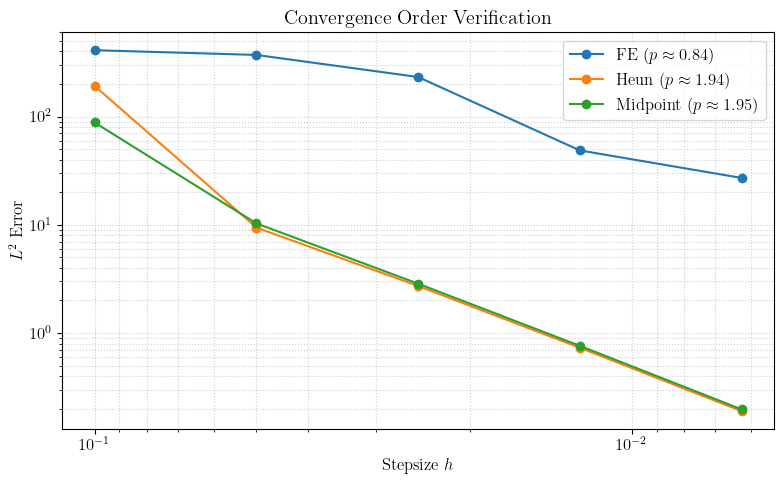

In [21]:
def compute_error(my_sol, ref_sol, h):
    return np.sqrt(np.sum(h * np.linalg.norm(np.abs(ref_sol - my_sol), axis=0)**2))

def compute_eoc(errors, hs):
    eocs = [np.inf]
    for i in range(1, len(errors)):
        p = np.log(errors[i-1] / errors[i]) / np.log(hs[i-1] / hs[i])
        eocs.append(p)
    return eocs

def compare_stepper(t0, tf, hs, stepper, ics):
    errors = []
    for h in hs:
        _ts, _sol = simulate_with_stepper(t0, tf, h, stepper, ics)
        _ref = solve_ivp(f, (t0, _ts[-1]), np.array(ics), method="DOP853", 
                         atol=1e-12, rtol=1e-12, t_eval=_ts)
        errors.append(compute_error(_sol, _ref.y, h))
    
    eocs = compute_eoc(errors, hs)
    return errors, eocs

names = ["FE", "Heun", "Midpoint"]
steppers = [forward_euler_step, heun_step, midpoint_step]
hs = [0.1 / 2**i for i in range(5)] 

plt.figure(figsize=(8, 5))

for name, stepper in zip(names, steppers):
    _errs, _eocs = compare_stepper(t_span[0], t_span[1], hs, stepper, y0)
    print(f"EOCs for {name}: {['%.3f' % e for e in _eocs]}")
    
    plt.loglog(hs, _errs, 'o-', label=rf"{name} ($p \approx {_eocs[-1]:.2f}$)")

plt.gca().invert_xaxis()
plt.grid(True, which="both", ls=':', alpha=0.6)
plt.xlabel(r'Stepsize $h$')
plt.ylabel(r'$L^2$ Error')
plt.title(r'Convergence Order Verification')
plt.legend()
plt.tight_layout()
plt.show()